This notebook modifies the example in `analysis_schema.Schema_Pydantic_Model.py` test out how to instantiate pydantic objects from an already validated json. 

This sets up a simplified pydantic model:

In [1]:
from enum import Enum
from pathlib import Path
from enum import Enum
from pydantic import BaseModel, Field, constr
from typing import Generic, List, Union, Dict, Optional
import pydantic
from pydantic.main import create_model
from uuid import UUID, uuid4
from dataclasses import dataclass

#from pydantic.types import ModelOrDc

# TO DO: 
# domain contexts - add class and add conditional logic. What classes, attributes, and methods should be subject to domain flexibility?
# start a spreadsheet / google doc to track this?
# ontologies? - add? pull from? 
# what are essential yt methods and attributes that need to be a part of each data class?
# - what of these attributes should the user not see (be set to private in pydantic)
# - What of these attributes should the user see/customize?
# - what of these atrributes are astro-specific? is there anything that is essential and astro-specific?

# for data ouptut - what in yt holds the data? What is data in yt? What should the schema refer to - create a mini-model to hold data output. Have user name that output, like a variable name? Have an id assigned to it?

# data ouput idea - turn data points into properties for re-use

# @dataclass
# class InputOutputMapping:
#     combo1: Dict[str, List[str]] = {'registration': ['selection', 'reduction', 'transformation']}

class Dataset(BaseModel):
    """ 
    The dataset model to load and that will be drawn from for other classes. Filename is the only required field. 
    """
    filename: str
    name: str = "Data for Science"
    comments: Optional[str] 
    grammar: str = "registration"

class Fields(BaseModel):
    field: str
    # unit - domain specific
    unit: str
    comments: Optional[str]
    grammar: str = "selection"

class AxisPlot(BaseModel):
    axis: str
    comments: Optional[str]

class Center(BaseModel):
    center: str
    comments: Optional[str]

class Widths(BaseModel):
    width: str
    comments: Optional[str]

class ColorMap(BaseModel):
    # list of pre-determined strings
    astro_map: str = "plasma"

class Scale(BaseModel):
    # list of pre-determined strings
    scale: str = "log"

class Average(BaseModel):
    average_field: Fields
    comments: Optional[str]
    grammar: str = "reduction"

class Sum(BaseModel):
    sum_field: Fields
    comments: Optional[str]
    grammar: str = "reduction"

class Operations(BaseModel):
    operation: Union[Sum, Average]

class _PlotAttributes(BaseModel):
    # necessary and private plotting functions for all plots
    PlottingWindow: str = "1.0"

class DataSource(BaseModel):
    dataset: Dataset
    data_selection: Union[Fields, Operations]

class SlicePlot(BaseModel):
    Data: DataSource
    AxisPlot: Optional[List[AxisPlot]]
    CenterPlot: Optional[Center]
    WidthPlot: Optional[List[Widths]]
    Comments: Optional[str]
    Annotation : bool = False
    # color map - domain specific
    ColorMap: str = None
    _PlotFunctions: _PlotAttributes


class ytModel(BaseModel):
    '''
    An example for a yt analysis schema using Pydantic
    '''
    Plot: List[SlicePlot]

    class Config:
        title = 'yt example'
        underscore_attrs_are_private = True



So let's assume the following json has come back from our json validator web framework:

In [2]:
# file_path = Path("Data.json")
# print(file_path)

validated_json = {'Plot': [{"Data": {"dataset": {"filename": "data.txt"}, 
                    "data_selection": {"field": "density", "unit": "kpc"}}}]}


we can instantiate a new `ytModel`:

In [4]:
test = ytModel(Plot = validated_json['Plot'])

In [5]:
test

ytModel(Plot=[SlicePlot(Data=DataSource(dataset=Dataset(filename='data.txt', name='Data for Science', comments=None, grammar='registration'), data_selection=Fields(field='density', unit='kpc', comments=None, grammar='selection')), AxisPlot=None, CenterPlot=None, WidthPlot=None, Comments=None, Annotation=False, ColorMap=None)])

and all the nested attributes are indeed instantiated pydantic classes:

In [8]:
p = test.Plot[0]

In [9]:
p

SlicePlot(Data=DataSource(dataset=Dataset(filename='data.txt', name='Data for Science', comments=None, grammar='registration'), data_selection=Fields(field='density', unit='kpc', comments=None, grammar='selection')), AxisPlot=None, CenterPlot=None, WidthPlot=None, Comments=None, Annotation=False, ColorMap=None)

In [10]:
type(p)

__main__.SlicePlot

In [14]:
p.schema_json()

'{"title": "SlicePlot", "type": "object", "properties": {"Data": {"$ref": "#/definitions/DataSource"}, "AxisPlot": {"title": "Axisplot", "type": "array", "items": {"$ref": "#/definitions/AxisPlot"}}, "CenterPlot": {"$ref": "#/definitions/Center"}, "WidthPlot": {"title": "Widthplot", "type": "array", "items": {"$ref": "#/definitions/Widths"}}, "Comments": {"title": "Comments", "type": "string"}, "Annotation": {"title": "Annotation", "default": false, "type": "boolean"}, "ColorMap": {"title": "Colormap", "type": "string"}}, "required": ["Data"], "definitions": {"Dataset": {"title": "Dataset", "description": "The dataset model to load and that will be drawn from for other classes. Filename is the only required field. ", "type": "object", "properties": {"filename": {"title": "Filename", "type": "string"}, "name": {"title": "Name", "default": "Data for Science", "type": "string"}, "comments": {"title": "Comments", "type": "string"}, "grammar": {"title": "Grammar", "default": "registration",

In [15]:
p.Data

DataSource(dataset=Dataset(filename='data.txt', name='Data for Science', comments=None, grammar='registration'), data_selection=Fields(field='density', unit='kpc', comments=None, grammar='selection'))

In [16]:
p.Data.dataset

Dataset(filename='data.txt', name='Data for Science', comments=None, grammar='registration')

In [17]:
p.Data.dataset.filename

'data.txt'

So all the things are there! Just giving the validated json to the top-level pydantic model instantiates all the referenced objects. 

So let's try modifying to add the recursive example. Here's a slightly modified version of the `ytBaseModel` class from the `ytBaseModelPrototype` notebook, now with an additional optional `yt_operation` attribute that specifies a `yt` function to call: 

In [51]:
from pydantic import BaseModel
from inspect import getfullargspec


class ytBaseModel(BaseModel):
    _arg_mapping: dict = {}  # mapping from internal yt name to schema name
    _yt_operation: Optional[str]
        
    def _run(self):
        # this method actually executes the yt code 
        
        # first make sure yt is imported and then get our function handle. This assumes
        # that our class name exists in yt's top level api.
        import yt
        print(self._yt_operation)
        
        funcname = getattr(self, "_yt_operation", type(self).__name__ )        
        func = getattr(yt, funcname)
        print(f"pulled func {func}")

        # now we get the arguments for the function:
        # func_spec.args, which lists the named arguments and keyword arguments.
        # ignoring vargs and kw-only args for now...
        # see https://docs.python.org/3/library/inspect.html#inspect.getfullargspec
        func_spec = getfullargspec(func)

        # the list that we'll use to eventually call our function
        the_args = []

        # the argument position number at which we have default values (a little hacky, should
        # be a better way to do this, and not sure how to scale it to include *args and **kwargs)
        n_args = len(func_spec.args)  # number of arguments
        if func_spec.defaults is None:
            # no default args, make sure we never get there...
            named_kw_start_at = n_args + 1
        else:
            # the position at which named keyword args start
            named_kw_start_at = n_args - len(func_spec.defaults)
        print(f"keywords start at {named_kw_start_at}")

        # loop over the call signature arguments and pull out values from our pydantic class .
        # this is recursive! will call _run() if a given argument value is also a ytBaseModel.
        for arg_i, arg in enumerate(func_spec.args):
            # check if we've remapped the yt internal argument name for the schema
            if arg in self._arg_mapping:
                arg = self._arg_mapping[arg]

            # get the value for this argument. If it's not there, attempt to set default values 
            # for arguments needed for yt but not exposed in our pydantic class
            print(arg)
            try:
                arg_value = getattr(self, arg)
            except AttributeError:
                if arg_i >= named_kw_start_at:
                    # we are in the named keyword arguments, grab the default
                    # the func_spec.defaults tuple 0 index is the first named
                    # argument, so need to offset the arg_i counter
                    default_index = arg_i - named_kw_start_at
                    arg_value = func_spec.defaults[default_index]
                else:
                    raise AttributeError

            # check if this argument is itself a ytBaseModel for which we need to run
            # this should make this a fully recursive function?
            # if hasattr(arg_value,'_run'):
            if isinstance(arg_value, ytBaseModel):
                print(f"{arg_value} is a ytBaseModel, calling {arg_value}._run() now...")
                arg_value = arg_value._run()

            the_args.append(arg_value)
        print(the_args)
        return func(*the_args)      
       

Ok, let's try this out with a simpler model:

In [78]:
class Dataset(ytBaseModel):
    """ 
    The dataset model to load and that will be drawn from for other classes. Filename is the only required field. 
    """
    filename: str
    name: str = "Data for Science"
    comments: Optional[str] 
    grammar: str = "registration"
    _yt_operation: str = "load"
    _arg_mapping: dict = {'fn' : 'filename'}

class ytModel(ytBaseModel):
    '''
    An example for a yt analysis schema using Pydantic
    '''
    Load: Dataset

    class Config:
        title = 'yt example'
        underscore_attrs_are_private = True
        
    def _run(self):
        # for the top level model, we override this. Nested objects will still be recursive!
        att = getattr(self, "Load")
        return att._run() 


In [71]:
test_j = {'Load': {"filename": "IsolatedGalaxy/galaxy0030/galaxy0030"}}
                           

In [72]:
ds_model = Dataset(**test_j['Load'])

In [73]:
ds_model._yt_operation

'load'

In [74]:
ds = ds_model._run()

yt : [INFO     ] 2021-04-09 16:24:18,165 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2021-04-09 16:24:18,166 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2021-04-09 16:24:18,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-04-09 16:24:18,167 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-04-09 16:24:18,167 Parameters: cosmological_simulation   = 0


load
pulled func <function load at 0x7f3739973950>
keywords start at 2
filename
['IsolatedGalaxy/galaxy0030/galaxy0030']


In [75]:
type(ds)

yt.frontends.enzo.data_structures.EnzoDataset

In [79]:
yt_mod = ytModel(Load = test_j['Load'])

In [80]:
yt_mod

ytModel(Load=Dataset(filename='IsolatedGalaxy/galaxy0030/galaxy0030', name='Data for Science', comments=None, grammar='registration'))

In [82]:
ds = yt_mod._run()

yt : [INFO     ] 2021-04-09 16:29:16,421 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2021-04-09 16:29:16,422 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2021-04-09 16:29:16,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-04-09 16:29:16,423 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-04-09 16:29:16,424 Parameters: cosmological_simulation   = 0


load
pulled func <function load at 0x7f3739973950>
keywords start at 2
filename
['IsolatedGalaxy/galaxy0030/galaxy0030']


Ok, let's return to a more complicated example:

In [213]:
from pydantic import BaseModel
from inspect import getfullargspec


class ytBaseModel(BaseModel):
    _arg_mapping: dict = {}  # mapping from internal yt name to schema name
    _yt_operation: Optional[str]
        
    def _run(self):
        # this method actually executes the yt code 
        
        # first make sure yt is imported and then get our function handle. This assumes
        # that our class name exists in yt's top level api.
        import yt
        print(self._yt_operation)
        
        funcname = getattr(self, "_yt_operation", type(self).__name__ )        
        func = getattr(yt, funcname)
        print(f"pulled func {func}")

        # now we get the arguments for the function:
        # func_spec.args, which lists the named arguments and keyword arguments.
        # ignoring vargs and kw-only args for now...
        # see https://docs.python.org/3/library/inspect.html#inspect.getfullargspec
        func_spec = getfullargspec(func)

        # the list that we'll use to eventually call our function
        the_args = []

        # the argument position number at which we have default values (a little hacky, should
        # be a better way to do this, and not sure how to scale it to include *args and **kwargs)
        n_args = len(func_spec.args)  # number of arguments
        if func_spec.defaults is None:
            # no default args, make sure we never get there...
            named_kw_start_at = n_args + 1
        else:
            # the position at which named keyword args start
            named_kw_start_at = n_args - len(func_spec.defaults)
        print(f"keywords start at {named_kw_start_at}")

        # loop over the call signature arguments and pull out values from our pydantic class .
        # this is recursive! will call _run() if a given argument value is also a ytBaseModel.
        for arg_i, arg in enumerate(func_spec.args):
            # check if we've remapped the yt internal argument name for the schema
            if arg in self._arg_mapping:
                arg = self._arg_mapping[arg]

            # get the value for this argument. If it's not there, attempt to set default values 
            # for arguments needed for yt but not exposed in our pydantic class
            print(arg)
            try:
                arg_value = getattr(self, arg)
            except AttributeError:
                if arg_i >= named_kw_start_at:
                    # we are in the named keyword arguments, grab the default
                    # the func_spec.defaults tuple 0 index is the first named
                    # argument, so need to offset the arg_i counter
                    default_index = arg_i - named_kw_start_at
                    arg_value = func_spec.defaults[default_index]
                else:
                    raise AttributeError

            # check if this argument is itself a ytBaseModel for which we need to run
            # this should make this a fully recursive function?
            # if hasattr(arg_value,'_run'):
            if isinstance(arg_value, ytBaseModel) or isinstance(arg_value, ytParameter):
                print(f"{arg_value} is a {type(arg_value)}, calling {arg_value}._run() now...")
                arg_value = arg_value._run()

            the_args.append(arg_value)
        print(the_args)
        return func(*the_args) 
    
class ytParameter(BaseModel):    
    _skip_these = ['comments']
    
    def _run(self):
        p = [getattr(self,key) for key in self.schema()['properties'].keys() if key not in self._skip_these]
        if len(p) > 1:
            raise ValueError("whoops. ytParameter instances can only have single values")
        return p[0]
    

In [214]:
yt_mod.schema()['properties']

{'Load': {'$ref': '#/definitions/Dataset'}}

In [215]:
from enum import Enum
from pathlib import Path
from enum import Enum
from pydantic import BaseModel, Field, constr
from typing import Generic, List, Union, Dict, Optional
import pydantic
from pydantic.main import create_model
from uuid import UUID, uuid4
from dataclasses import dataclass

#from pydantic.types import ModelOrDc

# TO DO: 
# domain contexts - add class and add conditional logic. What classes, attributes, and methods should be subject to domain flexibility?
# start a spreadsheet / google doc to track this?
# ontologies? - add? pull from? 
# what are essential yt methods and attributes that need to be a part of each data class?
# - what of these attributes should the user not see (be set to private in pydantic)
# - What of these attributes should the user see/customize?
# - what of these atrributes are astro-specific? is there anything that is essential and astro-specific?

# for data ouptut - what in yt holds the data? What is data in yt? What should the schema refer to - create a mini-model to hold data output. Have user name that output, like a variable name? Have an id assigned to it?

# data ouput idea - turn data points into properties for re-use

# @dataclass
# class InputOutputMapping:
#     combo1: Dict[str, List[str]] = {'registration': ['selection', 'reduction', 'transformation']}

class Dataset(ytBaseModel):
    """ 
    The dataset model to load and that will be drawn from for other classes. Filename is the only required field. 
    """
    filename: str
    name: str = "Data for Science"
    comments: Optional[str] 
    grammar: str = "registration"
    _yt_operation: str = "load"
    _arg_mapping: dict = {'fn' : 'filename'}

class Field(ytParameter):
    field: str

class Center(ytParameter):
    center: str
    comments: Optional[str]

class Widths(ytParameter):
    width: str
    comments: Optional[str]

class SlicePlot(ytBaseModel):
    Dataset: Dataset
    Field: Field
    Axis: str
    CenterPlot: Optional[Center]
    WidthPlot: Optional[List[Widths]]
    Comments: Optional[str]:
    _yt_operation: str = "SlicePlot"
    _arg_mapping: dict = {'ds' : 'Dataset', 'fields':'Field', 'axis': 'Axis', 'center': 'CenterPlot', 'width': 'WidthPlot'}                  


class ytModel(ytBaseModel):
    '''
    An example for a yt analysis schema using Pydantic
    '''
    Plot: List[SlicePlot]

    class Config:
        title = 'yt example'
        underscore_attrs_are_private = True

    def _run(self):
        # for the top level model, we override this. Nested objects will still be recursive!
        att = getattr(self, "Plot")
        return [p._run() for p in att]


In [216]:
validated_json = {'Plot': [{
                            "Dataset": {"filename": "IsolatedGalaxy/galaxy0030/galaxy0030"},
                            "Field": {"field": "density"},
                            "Axis" : "x"
                            }]}

In [217]:
mod = ytModel(Plot=validated_json['Plot'])

In [218]:
mod

ytModel(Plot=[SlicePlot(Dataset=Dataset(filename='IsolatedGalaxy/galaxy0030/galaxy0030', name='Data for Science', comments=None, grammar='registration'), Field=Field(field='density'), Axis='x', CenterPlot=None, WidthPlot=None, Comments=None)])

In [219]:
p = mod.Plot[0] 
p.Field.field

'density'

yt : [INFO     ] 2021-04-09 17:13:35,334 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2021-04-09 17:13:35,335 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2021-04-09 17:13:35,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-04-09 17:13:35,335 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-04-09 17:13:35,336 Parameters: cosmological_simulation   = 0
/home/chris/miniconda3/envs/yt_dev/lib/python3.7/site-packages/ipykernel_launcher.py:72: VisibleDeprecationWarning: SlicePlot's argument 'axis' is a deprecated alias for 'normal', it will be removed in a future version of yt.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
Parsing Hierarchy :  99%|█████████▉| 172/173 [00:00<00:00, 12962.60it/s]
yt : [INFO     ] 2021-04-09 17:13:35,358 Gathering a field list (this may take a moment.)


SlicePlot
pulled func <function SlicePlot at 0x7f37379b8710>
keywords start at 1
Dataset
filename='IsolatedGalaxy/galaxy0030/galaxy0030' name='Data for Science' comments=None grammar='registration' is a <class '__main__.Dataset'>, calling filename='IsolatedGalaxy/galaxy0030/galaxy0030' name='Data for Science' comments=None grammar='registration'._run() now...
load
pulled func <function load at 0x7f3739973950>
keywords start at 2
filename
['IsolatedGalaxy/galaxy0030/galaxy0030']
normal
Field
field='density' is a <class '__main__.Field'>, calling field='density'._run() now...
Axis
[galaxy0030, None, 'density', 'x']


yt : [INFO     ] 2021-04-09 17:13:36,778 xlim = 0.000000 1.000000
yt : [INFO     ] 2021-04-09 17:13:36,779 ylim = 0.000000 1.000000
yt : [INFO     ] 2021-04-09 17:13:36,780 xlim = 0.000000 1.000000
yt : [INFO     ] 2021-04-09 17:13:36,780 ylim = 0.000000 1.000000
yt : [INFO     ] 2021-04-09 17:13:36,781 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



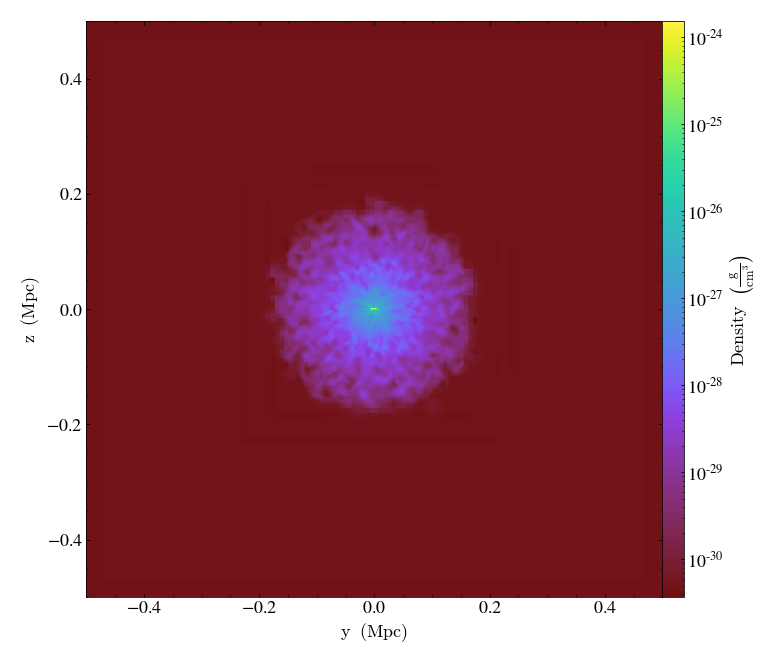

In [221]:
result = mod._run()
result[0].show()